# Solvers: SolverBase, EvolutionarySolver, DeterministicSolver

## Overview [Public API]

The role of a solver is to generate one or more candidate circuit (solution), which produces either an optimal or satisfactory state.

We have a fully-complete `EvolutionarySolver` as well as an in-progress deterministic solver.

Our `EvolutionarySolver` is a probabilistic solver where a population of candidate circuits are mutated and repeatedly evaluated / improved. This solver should be flexible/capable of targeting different circuit construction criteria. However, it is not guaranteed to produce a result of a certain quality.

Our `DeterministicSolver` follows a polynomial algorithm designed by Li et al, and can deterministically create a given target state. However, it is a) in development at the moment and b) restricted to a very particular objective (i.e. relies on particular hardware, cannot account for noise in the design).

Because the `DeterministicSolver` is not currently complete, we will focus on the `EvolutionarySolver` in this tutorial.

## `SolverBase` [Public API]

The `SolverBase` class is useful to consider all the possible inputs which can be provided to a given solver. Note that not every solver uses all input parameters, however.

The possible input parameters are:
* **target**: this is the target state which we aim to design. In some cases, it will not be used because the cost function metric will provide all necessary information. In other cases (e.g. with deterministic algorithms), it's essential
* **metric**: this is a cost function, which evaluates the "goodness" of a solution. For most heuristic optimization algorithms, this function is extremely important to the behaviour of the algorithm. Deterministic algorithms may not used it
* **compiler**: the compiler allows us to generate an output state given a target circuit
* **io**: this allows us to save information about the behaviour of the solver
* **circuit**: this is a potential initial circuit (we could see our heuristics around this original circuit, for example)

## `EvolutionarySolver` [Public API]

The `EvolutionarySolver` follows the algorithm below:
1. Initializes a group of candidate circuits, termed "population". Currently, the circuits are initialized as minimal. Each time we create a new population from the previous population, we call this a new "generation".
2. For each generation, the `EvolutionarySolver` applies a "mutation" (circuit change) to every candidate. 
3. Each (now mutated) candidate is evaluated with the cost function. The best individuals are saved to a "hall of fame" (hof). We may also update the solver logs, which tell us about the progress of the optimizations.
3. (optionally) The `EvolutionarySolver` picks out individual from the current general to form the next generation. This is called **selection**. For a fully random solver, we perform no selection and the next generation is formed by the mutated previous population.
4. When a certain number of generations or a termination condition is reached, the evolution ends.

Over generations, we expect the population to converge to better (fitter) individuals.

In [1]:
""" Setting up a solver: taken from quickstart """
import numpy as np

import src.backends.density_matrix.functions as dmf
from src.backends.density_matrix.compiler import DensityMatrixCompiler
from src.metrics import Infidelity
from src.state import QuantumState
from src.solvers.evolutionary_solver import EvolutionarySolver


ghz3_target_dm = dmf.ket2dm(
    (dmf.tensor(3 * [dmf.state_ketz0()]) + dmf.tensor(3 * [dmf.state_ketz1()]))
    / np.sqrt(2)
)
ghz3_target = QuantumState(3, ghz3_target_dm, representation="density matrix")

compiler = DensityMatrixCompiler()
DensityMatrixCompiler.measurement_determinism = 1

metric = Infidelity(target=ghz3_target)

# Now that we have a way to evaluate circuit quality, we can define a solver
solver = EvolutionarySolver(
    target=ghz3_target,  # target state we want to achieve
    metric=metric,  # how we judge the quality of a solution
    compiler=compiler,  # how we simulate our solution
    n_emitter=1,  # number of emitter qubits available as resources
    n_photon=3,  # number of photons making up the target state
    noise_model_mapping=None,  # we ignore noise in this example
)
solver.seed(1)  # this will allow us to replicate results reliably (fixes the rng)

### Circuit Initialization and Rules [Implementer Info]

We have rules for circuit initialization which reflects some physical realities of the quantum systems we want to implement. We also enforce some search space constraints to avoid solutions which are identical up to renumbering of qubits.
1. Each photon is created by an emitter. In the circuit, this is done via a controlled gate where the control is the emitter qubit, and the target is the photonic qubit. No gates can be applied on a photon before its creation
2. We create the photons in time-order of their numbering (i.e. photon i is created before photon j if i < j)
3. The emitters are ordered in the time-order where they release their first photon.
4. The last operation on each emitter is a classically controlled gate, where the measurement result from the emitter is used to control a photon.
5. We initial the circuits with only the photon-creating CNOTs, Hadamards on each photon, and the final classically controlled gates on emitters.

In addition, we limit the operations we can apply on photons in subsequent circuit changes:
* No controlled gates can be applied between pairs of photons (this is due to the experimental difficulty in creating those gates). Moreover, as there are only 24 single-qubit Clifford gates we can apply to the photons, we only allow one gate to be applied to each photon after their initialization (combinations of gates would reduce to one of the 24)


**Within the limits above, all circuit combinations are allowed.**

**NOTE**: the user does not have to deal with the initialization functions (it is handled in the solver)

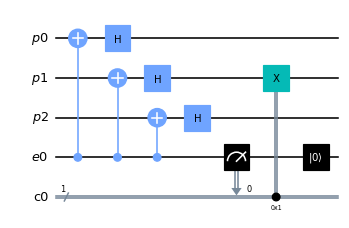

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [2]:
""" Solver circuit initialization examples """

# You can play around with the number of photons/emitters to see what different circuits you get!
# Note, however, that this is the simplest way to get a result out of your solver

n_photons = 3
n_emitter = 1
emission_assignment = EvolutionarySolver.get_emission_assignment(n_photons, n_emitter)
measurement_assignment = EvolutionarySolver.get_measurement_assignment(
    n_photons, n_emitter
)

circuit = solver.initialization(emission_assignment, measurement_assignment, {})
circuit.draw_circuit()

### Circuit Evolution Operations [Implementer Info]

What are the circuit mutations which evolve our population? They are a randomized version of the advanced circuit operations discussed in `2_circuits.ipynb`.

**NOTE:** The probability of each circuit transformation type being selected can be adjusted with the solver field `self.trans_probs` (transition probabilities). 

**Transformation types:**
* `replace_photon_one_qubit_op`: there is a single gate after each photon. This function selects a random photonic qubit, and swaps the gate (where the new gate probabilities follow `self.p_dist`, where each index of `p_dist` corresponds to the probability of one specific Clifford gate).
* `add_emitter_one_qubit_op`: this adds a single-qubit operation on an emitter (at any position). The new gate probabilities follow `self.e_dist`
* `add_emitter_cnot`: this adds a CNOT gate where both the control and target are emitter qubits. 
* `remove_op`: Picks an operation to remove (the photon initialization and final measurement/controlled gates cannot be removed)
* `add_measurement_cnot_and_reset`: this adds a measurement on an emitter qubit, the value of which determines whether or not a controlled gate is applied to a photonic qubit. The emitter is then reset to |0> 

**NOTE 1:** again, the operations in the example below are not typically directly by the user (they are regularly managed via the solver).

**NOTE 2:** The identity operation can be used to replace single-qubit gates **and it is not visible in the circuit, since it's equivalent to no operation**. Thus, if it seems like a post-photon gate was simply removed, it was replaced by an identity gate. The seeds in the example were selected to give interesting demonstrations.

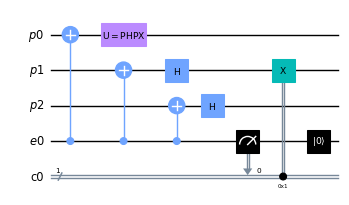

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [3]:
""" Looking at circuit operations... """
from copy import deepcopy

# replace photon one qubit op
solver.seed(8)
circuit_copy = deepcopy(circuit)
solver.replace_photon_one_qubit_op(circuit_copy)
circuit_copy.draw_circuit()

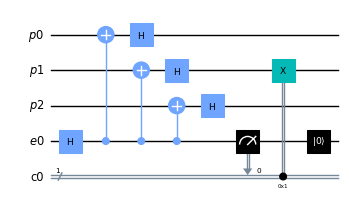

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [4]:
# add a gate to the emitter
solver.seed(0)
circuit_copy = deepcopy(circuit)
solver.add_emitter_one_qubit_op(circuit_copy)
circuit_copy.draw_circuit()

No demonstration for adding a `CNOT` between 2 emitters, since we only have one emitter in this example. But the API is the same.

Circuit with added nodes


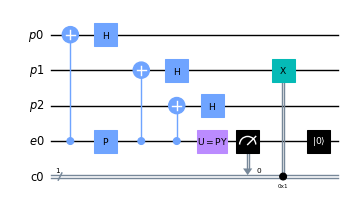

Circuit with a node removed (from previous drawn circuit)


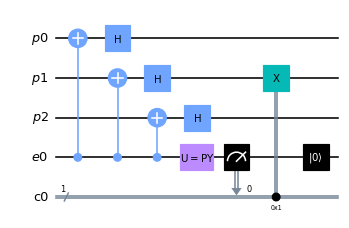

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [5]:
"""
Remove an operation
Since our previous circuit example doesn't have removable nodes, 
we'll also add a few nodes first
"""
solver.seed(1)
circuit_copy = deepcopy(circuit)
solver.add_emitter_one_qubit_op(circuit_copy)
solver.add_emitter_one_qubit_op(circuit_copy)
solver.add_emitter_one_qubit_op(circuit_copy)
print(f"Circuit with added nodes")
circuit_copy.draw_circuit()

solver.remove_op(circuit_copy)
print(f"Circuit with a node removed (from previous drawn circuit)")
circuit_copy.draw_circuit()

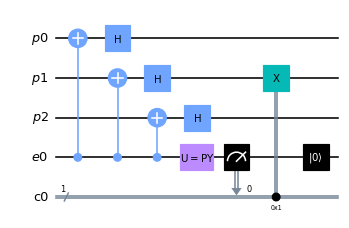

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [6]:
# add a measurement+CNOT+reset
# TODO: check whether we expect it not to add anything...
# I would expect it to be able to add things between the last CNOT following gate...
solver.seed(0)
circuit_copy_2 = deepcopy(circuit_copy)
solver.add_measurement_cnot_and_reset(circuit_copy_2)
circuit_copy.draw_circuit()

## Customizing the `EvolutionarySolver` [General API]

Evolutionary algorithms must often be tuned for best performance. Our solver allows the following hyperparameters:

**Solver class hyperparameters:** these are changed through the class, not the individual object (though that's a somewhat arbitrary choice)
* `use_adapt_probability`: boolean value, which determines whether the probability of different circuit evolution operations change over time (set to `False` for now, since the adaptive probabilities were not tuned to improve performance). 

**Solver object parameters**: these are changed specifically to the object
* `n_stop`: the number of generations run by the algorithm
* `n_pop`: the size of the candidate circuit population
* `tournament_k`: the best individuals of a given population are selected to move to the next generation via tournament selection (more later). This hyperparameter determines the trade-off between diversity of solution, and capitalizing on best individuals.
* `self.p_dist`/`self.e_dist` (as previously explained)
* `self.trans_probs`: the probability of different operators being selected to modify the circuit
* `self.selection_active`: if True, we do some selection after each generation. Otherwise, there is no selection and we port mutated individuals directly to the next generation (no selection is the default)
* `self.noise_simulation`: if true, the optimization is performed with noise. Otherwise, the optimization is noiseless.
* `n_hof`: the number of different circuits we maintain in the hall of fame
* `self.noise_model_mapping`: noise models (as previously discussed)
* `self.save_openqasm`: whether we want to save the circuit population, hof, or both to openQASM strings

In [7]:
""" Example where we mess around with settings to 'tune' our solver"""

solver.n_stop = 20
solver.n_pop = 100
solver.tournament_k = 3

print(f"default transformation probs: {solver.trans_probs}")  # we will keep these as is

# Set equal probability for all single-qubit clifford gates
solver.p_dist = [1 / 24] * 24
solver.e_dist = [1 / 24] * 24

solver.solve()

default transformation probs: {<bound method EvolutionarySolver.add_emitter_one_qubit_op of <src.solvers.evolutionary_solver.EvolutionarySolver object at 0x000001ECEB3F0C70>>: 0.3333333333333333, <bound method EvolutionarySolver.replace_photon_one_qubit_op of <src.solvers.evolutionary_solver.EvolutionarySolver object at 0x000001ECEB3F0C70>>: 0.3333333333333333, <bound method EvolutionarySolver.remove_op of <src.solvers.evolutionary_solver.EvolutionarySolver object at 0x000001ECEB3F0C70>>: 0.3333333333333333}
Iteration 0 | Best score: 0.750000
Iteration 1 | Best score: 0.750000
Iteration 2 | Best score: 0.500000
Iteration 3 | Best score: 0.500000
Iteration 4 | Best score: 0.500000
Iteration 5 | Best score: 0.500000
Iteration 6 | Best score: 0.500000
Iteration 7 | Best score: 0.500000
Iteration 8 | Best score: 0.500000
Iteration 9 | Best score: 0.500000
Iteration 10 | Best score: 0.500000
Iteration 11 | Best score: 0.500000
Iteration 12 | Best score: 0.500000
Iteration 13 | Best score: 0

## Understanding the hall of fame [Public API]

The hall of fame is a list of the best tuples `(ciruit score, circuit)` which we encounter during optimization. This prevents us from losing the best solutions found.

At each iteration, we update it with the best individuals of the new generation (if any of them exceeded the quality of previous hall of fame individuals).

Currently, it is entirely possible for our hall of fame to contain duplicate circuits, since the evolution process is likely to generate the same circuit multiple times. In the future, we would want to add a check and forbid duplicates.

## Understanding selection

Selection is the process by which candidate individuals of a population progress to the next generation (named after natural selection).

Suppose that we have mutated every individual of generation X. Let's call our candidate list $S$ where $(score, candidate) \in S$ for each cost function score + circuit pair.

We can build our next population of any candidate where $(score, candidate) \in S$. We can in theory pick any candidate any number of time (until the population is full)--repeat circuits are fine since they have the potential to evolve differently. 

**Tournament selection**
Tournament selection is a form of selection, where we repeatedly sample $k$ different candidate circuits, and pick the candidate $c_i$ with the score $s_i > s_j, \forall j \neq i$ to go into the population. We repeat this process until the next generation has the desired size.

Then, with a large $k$, we are extremely likely to pick the best individuals and push them to the next generation. This can be useful, but can also reduce the variety of our population (making it more likely to get stuck in a local optimum).

In contrast, with a smaller $k$, our selection is more random. This keeps our population diverse, but means that we're learning less from the better circuits.

The optimal value of k is something that must be tuned, in general.

## Improvement Suggestions for `EvolutionarySolver`
* Add elitism (best individuals of a population are guaranteed a pass to the next generation)
* Improve the hall of fame to eliminate redundant circuit solutions
* Try a geometric probability adaptation rather than a linear one (i.e. transition probabilities change by a constant multiplying factor rather than a constant subtraction factor)
* Currently, not all mutation operators of the `EvolutionarySolver` are effective (some of them "mutate" the state into the same state, for example replacing a certain gate by itself). We should change the code so that a change MUST occur.

## `DeterministicSolver` [Public API]

Deterministic solver which follows the paper by Li et al [1].  
[1] Bikun Li, Sophia E. Economou and Edwin Barnes, npj. Quantum Information 8, 11 (2022)  

D:\Jobs\Ki3\graph-compiler\src\state.py:238: UserWarning: Stabilizer representation being set is not compared to previously existing representations. Make sure the newrepresentation is consistent with other object representations
  warnings.warn(


Circuit generated from deterministic solver


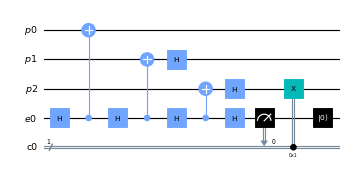

Target circuit


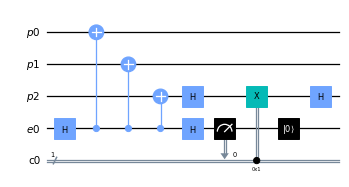

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [8]:
""" Solver circuit initialization examples """
from benchmarks.circuits import *
from src.backends.stabilizer.compiler import StabilizerCompiler
from src.backends.density_matrix.compiler import DensityMatrixCompiler
from src.backends.density_matrix.functions import fidelity
from src.solvers.deterministic_solver import DeterministicSolver

compiler = StabilizerCompiler()
target_circuit, target = ghz3_state_circuit()
metric = Infidelity(target)

solver = DeterministicSolver(
    target=target,
    metric=metric,
    compiler=compiler,
)

solver.solve()
score, circuit = solver.result

print("Circuit generated from deterministic solver")
circuit.draw_circuit()

print("Target circuit")
target_circuit.draw_circuit()